## Pipeline Overview — **SynGNet**
*A synteny-driven graph neural framework for species-level phylogenomic inference*

---

### 1. Data and Feature Engineering

- **Load raw inputs**:
  - edges — gene–gene synteny relationships  
  - nodes — per-gene attributes

- **Aggregate edge-derived signals per gene**:
  - block_score, block_N (anchor count proxy)
  - BLAST statistics: identity, alignment_length, bitscore, -log10(evalue)
  - Orientation, strand indicators, graph degree (deg)

- **Positional and contextual features**:
  - Chromosomal position features: pos_norm, clipped and cleaned
  - Species-wise position z-score: pos_z_in_species
  - Chromosome-relative metrics: chr_rel_pos, distance to left/right ends (min_end_dist)
  - Positional neighborhood statistics: mean/median/std of neighbor pos_norm
  - Positional binning: one-hot encoding pos_bin_0 … pos_bin_9

- **Assemble final feature matrix**:
  - Construct feat_df with NaN-safe numerical columns
  - Save standardized table as gene_features.csv

---

### 2. Graph Construction

- **Nodes**: genes represented by standardized numerical features (X)
- **Edges**: bidirectional synteny-derived gene–gene connections (edge_index)
- **Labels**: species IDs encoded via LabelEncoder
- **Species similarity matrix**:
  sp_sp_sim computed from species co-occurrence on edges, normalized row-wise

---

### 3. Model Architecture — **SynGNet**

#### 🔹 LightCNNTransformerGNN backbone

1. **Input projection**  
   Linear(in_dim → in_dim)

2. **DepthWiseCNN1D**  
   Channel-wise convolution to smooth local feature signals, combined with LayerNorm and Dropout

3. **TinyFeatureTransformer**  
   - Treat each numeric feature as a token  
   - Project to d_model, add positional embedding from pos_norm  
   - Apply a 1-layer TransformerEncoder  
   - Project back to scalar dimension  
   - Supports extraction of attention matrices for interpretability

4. **Feature fusion**  
   CNN output + Transformer output → LayerNorm → Linear → hidden_dim

5. **Graph aggregation**  
   Mean neighbor aggregation via scatter, followed by residual MLP and LayerNorm

6. **Classification head**  
   MLP → species logits

**Forward returns**:
- Node embeddings z  
- Species logits

---

### 4. Species-Aware Training Objectives

Total loss components:

- CE: cross-entropy classification loss
- Intra: compactness of embeddings within each species center
- Inter: margin-based separation between species centers
- Spec_graph: species-center distance penalty weighted by sp_sp_sim

\[
\mathcal{L} = \lambda_\text{ce} CE + \lambda_\text{intra} Intra + \lambda_\text{inter} Inter + \lambda_\text{spec} Spec\_graph
\]

Best checkpoint tracked automatically during training.



### 5. Reproducibility

- Fixed seeds for Python, NumPy, PyTorch, CUDA
- Deterministic cuDNN setup; dropout disabled during inference
- Device metadata stored for exact experiment reruns

---

### 6. Execution Flow

1. Feature aggregation  
2. Graph construction and label encoding  
3. Species similarity computation  
4. Initialize and train SynGNet  
5. Save embeddings, logits, and model checkpoints  
6. Generate species embeddings via Graph Transformer pooling and dendrogram  
7. Extract attention signals and produce visualizations

---

**SynGNet** integrates genome synteny, positional context, and graph neural reasoning to quantify evolutionary relationships without sequence alignment.


#### step 0: Environment

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import math
import random
import re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from torch_geometric.data import Data
    from torch_geometric.nn import TransformerConv
    PYG_AVAILABLE = True
except Exception as e:
    print("[WARN] PyG missing; please install torch_geometric for full training.", e)
    PYG_AVAILABLE = False

/home/bmi3p6/miniconda3/envs/synnet1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### step 1: load data

In [2]:
RNG_SEED = 7
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

torch.cuda.set_device(1)
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
EPS = 1e-9

# All results will be saved under 'result_1'
OUT_DIR = "./Synteny_features—20plasmo2" # You can change the output directory here
os.makedirs(OUT_DIR, exist_ok=True)

print(f"[Info] Device={DEVICE}, PyG={PYG_AVAILABLE}")



# Load Data

EDGE_PATH = "/home/bmi3p6/LiZhibo/20plasmo2/edge_plasmo2.tsv" # You can change the edge file path here
NODE_PATH = "/home/bmi3p6/LiZhibo/20plasmo2/node_plasmo2.tsv" # You can change the node file path here

edges = pd.read_csv(EDGE_PATH, sep="\t")
nodes = pd.read_csv(NODE_PATH, sep="\t")

print("[INFO] edges:", edges.shape)
print("[INFO] nodes:", nodes.shape)





[Info] Device=cuda:1, PyG=True


/tmp/ipykernel_1259072/3997519366.py:26: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv(EDGE_PATH, sep="\t")


[INFO] edges: (2863468, 15)
[INFO] nodes: (102853, 10)


#### step 1: Feature extraction

In [3]:

# Aggregate Edge Features per Gene

edge_agg = defaultdict(lambda: defaultdict(list))
deg = defaultdict(int)

for row in edges.itertuples(index=False):
    g1, g2 = row.gene1, row.gene2
    for g in (g1, g2):
        deg[g] += 1

        # block_score / N
        if getattr(row, "block_score", "") != "":
            try:
                edge_agg[g]["block_score"].append(float(row.block_score))
            except Exception:
                pass
        if getattr(row, "block_N", "") != "":
            try:
                edge_agg[g]["block_N"].append(float(row.block_N))
            except Exception:
                pass

        # BLAST numerical features
        if getattr(row, "blast_identity", "") != "":
            try:
                edge_agg[g]["blast_identity"].append(float(row.blast_identity))
            except Exception:
                pass
        if getattr(row, "blast_align_len", "") != "":
            try:
                edge_agg[g]["blast_align_len"].append(float(row.blast_align_len))
            except Exception:
                pass
        if getattr(row, "blast_bitscore", "") != "":
            try:
                edge_agg[g]["blast_bitscore"].append(float(row.blast_bitscore))
            except Exception:
                pass
        if getattr(row, "blast_evalue", "") not in ("", None):
            try:
                val = float(row.blast_evalue)
                edge_agg[g]["blast_log_eval"].append(-np.log10(val + 1e-300))
            except Exception:
                pass

        # Orientation features
        edge_agg[g]["orient_plus"].append(1.0 if getattr(row, "block_orient", "") == "plus" else 0.0)
        edge_agg[g]["orient_minus"].append(1.0 if getattr(row, "block_orient", "") == "minus" else 0.0)
        edge_agg[g]["blast_strand_plus"].append(1.0 if getattr(row, "blast_strand", "") == "plus" else 0.0)
        edge_agg[g]["blast_strand_minus"].append(1.0 if getattr(row, "blast_strand", "") == "minus" else 0.0)


def reduce_list(arr):
    if len(arr) == 0:
        return {"sum": 0.0, "mean": 0.0, "max": 0.0, "min": 0.0, "count": 0.0}
    a = np.array(arr, dtype=float)
    return {
        "sum": float(a.sum()),
        "mean": float(a.mean()),
        "max": float(a.max()),
        "min": float(a.min()),
        "count": float(len(a)),
    }



# Encode Chromosome Labels
if "chr" in nodes.columns:
    chr_col = "chr"
elif "chrom" in nodes.columns:
    chr_col = "chrom"
else:
    chr_col = None

if chr_col is not None:
    chr_series = nodes[chr_col].astype(str).fillna("").values
    chr_encoder = LabelEncoder()
    chr_encoder.fit(chr_series)
else:
    chr_encoder = None

# Position-related helpers (robust)
#First, uniformly clean up pos_norm
if "pos_norm" in nodes.columns:
    nodes["pos_norm"] = pd.to_numeric(nodes["pos_norm"], errors="coerce")
    nodes["pos_norm"] = nodes["pos_norm"].fillna(0.0)
    nodes.loc[~np.isfinite(nodes["pos_norm"]), "pos_norm"] = 0.0
    # If it can be cropped within the range of 0 to 1
    nodes["pos_norm"] = nodes["pos_norm"].clip(0.0, 1.0)

# Intraspecific statistics
if "species" in nodes.columns:
    tmp = nodes[["gene_id", "species", "pos_norm"]].copy()
    tmp["species"] = tmp["species"].astype(str)
    sp_pos_mean = tmp.groupby("species")["pos_norm"].mean()
    sp_pos_std = tmp.groupby("species")["pos_norm"].std().fillna(0.0)
else:
    sp_pos_mean = pd.Series(dtype=float)
    sp_pos_std = pd.Series(dtype=float)

# Estimation of chromosome length
if chr_col is not None and "pos_norm" in nodes.columns:
    chr_len_est = nodes.groupby(chr_col)["pos_norm"].max().fillna(1.0)
else:
    chr_len_est = pd.Series(dtype=float)

# Reconstruction mapping (after cleaning)
gene_to_species = dict(zip(nodes["gene_id"], nodes["species"])) if "species" in nodes.columns else {}
gene_to_chr = dict(zip(nodes["gene_id"], nodes[chr_col])) if chr_col is not None else {}
gene_to_pos = dict(zip(nodes["gene_id"], nodes["pos_norm"])) if "pos_norm" in nodes.columns else {}

def _finite(v, default=0.0):
    try:
        vv = float(v)
        return vv if np.isfinite(vv) else float(default)
    except Exception:
        return float(default)

def pos_z_in_species(gid):
    sp = str(gene_to_species.get(gid, ""))
    p = _finite(gene_to_pos.get(gid, 0.0), 0.0)
    m = _finite(sp_pos_mean.get(sp, 0.0), 0.0)
    s = _finite(sp_pos_std.get(sp, 0.0), 0.0)
    s = s if s > 1e-8 else 1.0
    return (p - m) / s

def chr_rel_pos(gid):
    p = _finite(gene_to_pos.get(gid, 0.0), 0.0)
    if chr_col is None:
        return min(max(p, 0.0), 1.0)
    ch = gene_to_chr.get(gid, None)
    L = _finite(chr_len_est.get(ch, 1.0) if ch in chr_len_est.index else 1.0, 1.0)
    if L <= 1e-8: L = 1.0
    rp = p / L
    return min(max(rp, 0.0), 1.0)

def chr_end_dist_features(gid):
    rp = chr_rel_pos(gid)
    return rp, 1.0 - rp, min(rp, 1.0 - rp)

def pos_bin_onehot(gid, bins=10):
    rp = chr_rel_pos(gid)
    # rp has been guaranteed to be within the range of [0,1]
    idx = int(min(bins - 1, max(0, math.floor(rp * bins))))
    oh = np.zeros(bins, dtype=float)
    oh[idx] = 1.0
    return oh

# Neighbor Location Statistics
from collections import defaultdict
neighbor_pos = defaultdict(list)
for row in edges.itertuples(index=False):
    g1, g2 = row.gene1, row.gene2
    if g2 in gene_to_pos:
        neighbor_pos[g1].append(_finite(gene_to_pos[g2], np.nan))
    if g1 in gene_to_pos:
        neighbor_pos[g2].append(_finite(gene_to_pos[g1], np.nan))

def neighbor_pos_stats(gid):
    arr = [v for v in neighbor_pos.get(gid, []) if np.isfinite(v)]
    if len(arr) == 0:
        return 0.0, 0.0, 0.0
    a = np.array(arr, dtype=float)
    return float(a.mean()), float(np.median(a)), float(a.std(ddof=0))


#### step 2.2 Aggregation + Feature DataFrame (NaN-safe)

In [4]:



edge_count = {g: int(deg.get(g, 0)) for g in set(list(deg.keys()) + list(edge_agg.keys()))}

block_score_sum = {}
blast_identity_sum = {}
blast_bitscore_sum = {}
blast_align_len_sum = {}
blast_log_eval_sum = {}
anchor_count = {}
orient_plus_count = {}

for g, feats in edge_agg.items():
    bs = feats.get("block_score", [])
    bi = feats.get("blast_identity", [])
    bb = feats.get("blast_bitscore", [])
    ba = feats.get("blast_align_len", [])
    be = feats.get("blast_log_eval", [])
    bN = feats.get("block_N", [])
    op = feats.get("orient_plus", [])

    block_score_sum[g] = float(np.sum(bs)) if len(bs) else 0.0
    blast_identity_sum[g] = float(np.sum(bi)) if len(bi) else 0.0
    blast_bitscore_sum[g] = float(np.sum(bb)) if len(bb) else 0.0
    blast_align_len_sum[g] = float(np.sum(ba)) if len(ba) else 0.0
    blast_log_eval_sum[g] = float(np.sum(be)) if len(be) else 0.0

    try:
        anchor_count[g] = int(sum(1 for v in bN if _finite(v, 0.0) > 0.0))
    except Exception:
        anchor_count[g] = 0
    orient_plus_count[g] = int(np.sum(op)) if len(op) else 0

from collections import defaultdict as _dd
block_score_sum = _dd(float, block_score_sum)
blast_identity_sum = _dd(float, blast_identity_sum)
blast_bitscore_sum = _dd(float, blast_bitscore_sum)
blast_align_len_sum = _dd(float, blast_align_len_sum)
blast_log_eval_sum = _dd(float, blast_log_eval_sum)
anchor_count = _dd(int, anchor_count)
orient_plus_count = _dd(int, orient_plus_count)
edge_count = _dd(int, edge_count)

feat_rows = []
for row in nodes.itertuples(index=False):
    gid = getattr(row, "gene_id", None)
    if gid is None:
        continue

    ec = int(edge_count.get(gid, 0))
    gene_length = _finite(getattr(row, "gene_length", 0.0), 0.0)
    pos_norm = _finite(getattr(row, "pos_norm", 0.0), 0.0)

    if chr_col is not None:
        chr_raw = getattr(row, chr_col, "")
        chr_raw = str(chr_raw)
        try:
            chr_id = int(chr_encoder.transform([chr_raw])[0])
        except Exception:
            chr_id = 0
    else:
        chr_id = 0

    mean_block_score = block_score_sum[gid] / ec if ec > 0 else 0.0
    mean_identity = blast_identity_sum[gid] / ec if ec > 0 else 0.0
    mean_bitscore = blast_bitscore_sum[gid] / ec if ec > 0 else 0.0
    orient_ratio = orient_plus_count[gid] / ec if ec > 0 else 0.0

    rel_pos = chr_rel_pos(gid)
    pos_z_sp = pos_z_in_species(gid)
    left_dist, right_dist, min_end_dist = chr_end_dist_features(gid)
    nb_pos_mean, nb_pos_median, nb_pos_std = neighbor_pos_stats(gid)
    pos_bins_oh = pos_bin_onehot(gid, bins=10)

    row_dict = {
        "gene_id": gid,
        "species": getattr(row, "species", "") if "species" in nodes.columns else "",
        "gene_length": gene_length,
        "pos_norm": pos_norm,
        "chr_id": chr_id,
        "deg": int(deg.get(gid, 0)),
        "mean_block_score": mean_block_score,
        "mean_identity": mean_identity,
        "mean_bitscore": mean_bitscore,
        "anchor_count": int(anchor_count.get(gid, 0)),
        "orient_plus_ratio": orient_ratio,
        "chr_rel_pos": rel_pos,
        "pos_z_in_species": pos_z_sp,
        "chr_left_dist": left_dist,
        "chr_right_dist": right_dist,
        "chr_min_end_dist": min_end_dist,
        "neighbor_pos_mean": nb_pos_mean,
        "neighbor_pos_median": nb_pos_median,
        "neighbor_pos_std": nb_pos_std,
    }
    for i, v in enumerate(pos_bins_oh):
        row_dict[f"pos_bin_{i}"] = float(v)

    feat_rows.append(row_dict)


feat_df = pd.DataFrame(feat_rows).fillna(0)
print("[INFO] feature df (with positional features, NaN-safe):", feat_df.shape)

num_cols = feat_df.select_dtypes(include=[np.number]).columns.tolist()
non_finite_cols = {c: int((~np.isfinite(feat_df[c].astype(float))).sum()) for c in num_cols}
bad = {c: v for c, v in non_finite_cols.items() if v > 0}
if bad:
    print("[WARN] Non-finite counts:", bad)

feat_df.to_csv(os.path.join(OUT_DIR, "gene_features.csv"), index=False)


[INFO] feature df (with positional features, NaN-safe): (102853, 29)


#### step 2.3 Constructing the edge_index required for PyTorch Geometric

In [5]:
import torch
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import scatter


RESULT_DIR = "./embedding_training—20plasmo2" # You can change the result directory here
os.makedirs(RESULT_DIR, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


feat_df_path = "./Synteny_features—20plasmo2/gene_features.csv" # You can change the feature file path here
if not os.path.exists(feat_df_path):
    raise FileNotFoundError(f"Expected feature file not found: {feat_df_path}")

feat_df = pd.read_csv(feat_df_path)
print(f"[INFO] Loaded feat_df from {feat_df_path}, shape: {feat_df.shape}")

print(f"[INFO] Loaded edges from {EDGE_PATH}, shape: {edges.shape}")


genes = list(feat_df["gene_id"])
g2i = {g: i for i, g in enumerate(genes)}

edge_index_list = []
for row in edges.itertuples(index=False):
    if row.gene1 in g2i and row.gene2 in g2i:
        u = g2i[row.gene1]
        v = g2i[row.gene2]
        edge_index_list.append([u, v])
        edge_index_list.append([v, u])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
print("[INFO] edge_index:", edge_index.shape)

[INFO] Loaded feat_df from ./Synteny_features—20plasmo2/gene_features.csv, shape: (102853, 29)
[INFO] Loaded edges from /home/bmi3p6/LiZhibo/20plasmo2/edge_plasmo2.tsv, shape: (2863468, 15)
[INFO] edge_index: torch.Size([2, 5726936])


#### step 2.4 Encode species labels and assemble graph data for GNN training

In [6]:

sp_encoder = LabelEncoder()
feat_df["sp_id"] = sp_encoder.fit_transform(feat_df["species"])
y = torch.tensor(feat_df["sp_id"].values, dtype=torch.long)

exclude_cols = ["gene_id", "species", "sp_id"]
numeric_cols = [c for c in feat_df.columns if c not in exclude_cols]
print("[INFO] Using numeric features:", numeric_cols)

X = feat_df[numeric_cols].astype(float).values


scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

from torch_geometric.data import Data

data = Data(x=X, edge_index=edge_index, y=y)

idx2sp = {i: sp for i, sp in enumerate(sp_encoder.classes_)}
sp2idx = {sp: i for i, sp in idx2sp.items()}

print("[INFO] ", data)
print("[INFO] #species:", len(sp_encoder.classes_))
print("[INFO] species -> index mapping saved.")

import json
with open(os.path.join(RESULT_DIR, "species_mapping.json"), "w") as f:
    json.dump({"idx2sp": idx2sp, "sp2idx": sp2idx}, f, indent=2)

species_list = sorted(
    set(edges["species1"].dropna().unique()) |
    set(edges["species2"].dropna().unique())
)

sp2idx_edge = {sp: i for i, sp in enumerate(species_list)}
idx2sp_edge = {i: sp for sp, i in sp2idx_edge.items()}
S = len(species_list)

print("Detected species from edges:", species_list)

[INFO] Using numeric features: ['gene_length', 'pos_norm', 'chr_id', 'deg', 'mean_block_score', 'mean_identity', 'mean_bitscore', 'anchor_count', 'orient_plus_ratio', 'chr_rel_pos', 'pos_z_in_species', 'chr_left_dist', 'chr_right_dist', 'chr_min_end_dist', 'neighbor_pos_mean', 'neighbor_pos_median', 'neighbor_pos_std', 'pos_bin_0', 'pos_bin_1', 'pos_bin_2', 'pos_bin_3', 'pos_bin_4', 'pos_bin_5', 'pos_bin_6', 'pos_bin_7', 'pos_bin_8', 'pos_bin_9']
[INFO]  Data(x=[102853, 27], edge_index=[2, 5726936], y=[102853])
[INFO] #species: 20
[INFO] species -> index mapping saved.
Detected species from edges: ['Hpiliocolobus2019', 'HtartakovskyiSISKIN1', 'PadleriG01', 'PbillcollinsiG01', 'PblacklockiG01', 'PbrasilianumBolivianI', 'Pchabaudichabaudi', 'PcoatneyiHackeri', 'PcynomolgiB', 'PcynomolgiM', 'Pfalciparum3D7', 'PfalciparumIT', 'PfalciparumKE01', 'PfalciparumKH01', 'PfalciparumKH02', 'PfalciparumML01', 'PfalciparumNF135C10', 'PfalciparumNF166', 'PfalciparumNF54', 'PfalciparumSN01']


#### step 2.5: Build Species Co-occurrence Similarity Matrix

In [7]:
sp_counts = np.zeros((S, S), dtype=float)

for row in edges.itertuples(index=False):
    s1 = getattr(row, "species1", None)
    s2 = getattr(row, "species2", None)

    if s1 not in sp2idx_edge or s2 not in sp2idx_edge:
        continue

    i = sp2idx_edge[s1]
    j = sp2idx_edge[s2]

    sp_counts[i, j] += 1.0
    sp_counts[j, i] += 1.0

row_sums = sp_counts.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
sp_sim = sp_counts / row_sums

sp_sp_sim = torch.tensor(sp_sim, dtype=torch.float32, device=DEVICE)

print("sp_sp_sim shape:", sp_sp_sim.shape)
print(sp_sp_sim)

sp_sp_sim shape: torch.Size([20, 20])
tensor([[0.0614, 0.0350, 0.0542, 0.0167, 0.0523, 0.0513, 0.0532, 0.0520, 0.0501,
         0.0529, 0.0541, 0.0531, 0.0530, 0.0521, 0.0529, 0.0491, 0.0497, 0.0514,
         0.0522, 0.0533],
        [0.0504, 0.0706, 0.0529, 0.0168, 0.0512, 0.0498, 0.0505, 0.0506, 0.0478,
         0.0511, 0.0526, 0.0517, 0.0517, 0.0510, 0.0516, 0.0480, 0.0485, 0.0504,
         0.0510, 0.0520],
        [0.0440, 0.0299, 0.0600, 0.0201, 0.0550, 0.0442, 0.0433, 0.0441, 0.0423,
         0.0444, 0.0583, 0.0572, 0.0565, 0.0580, 0.0575, 0.0594, 0.0546, 0.0556,
         0.0569, 0.0587],
        [0.0365, 0.0256, 0.0541, 0.0450, 0.0457, 0.0365, 0.0359, 0.0356, 0.0348,
         0.0364, 0.0624, 0.0591, 0.0596, 0.0635, 0.0606, 0.0704, 0.0566, 0.0578,
         0.0607, 0.0633],
        [0.0461, 0.0314, 0.0596, 0.0184, 0.0591, 0.0448, 0.0454, 0.0450, 0.0439,
         0.0456, 0.0574, 0.0567, 0.0557, 0.0564, 0.0564, 0.0565, 0.0535, 0.0548,
         0.0558, 0.0575],
        [0.0491, 0.033

#### step 3:Build the model

In [8]:
from torch_geometric.nn import TransformerConv
class DepthWiseCNN1D(nn.Module):
    def __init__(self, feat_dim, kernel_size=3, dropout=0.1):
        super().__init__()
        padding = kernel_size // 2
        self.dw_conv = nn.Conv1d(feat_dim, feat_dim, kernel_size=kernel_size,
                                 padding=padding, groups=feat_dim, bias=False)
        self.norm = nn.LayerNorm(feat_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = self.dw_conv(x)
        x = x.squeeze(2)
        x = self.norm(x)
        x = self.dropout(x)
        return x


class TinyFeatureTransformer(nn.Module):
    def __init__(self, feat_dim, d_model=16, nhead=2, num_layers=1, dropout=0.1, pos_encoding=None):
        super().__init__()
        self.feat_dim = feat_dim
        self.d_model = d_model

        self.proj_in = nn.Linear(1, d_model)
        if pos_encoding is not None:
            self.register_buffer('pos_emb', pos_encoding)  # shape: (1, feat_dim, d_model)
        else:
            self.pos_emb = nn.Parameter(torch.zeros(1, feat_dim, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.proj_out = nn.Linear(d_model, 1)

        self.norm = nn.LayerNorm(feat_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, F = x.shape

        x = x.unsqueeze(-1)
        x = self.proj_in(x)

        x = x + self.pos_emb[:, :F, :]

        x = self.transformer(x)

        x = self.proj_out(x)
        x = x.squeeze(-1)

        x = self.norm(x)
        x = self.dropout(x)
        return x
    
    
    def extract_attention(self, x, max_features=80):
        self.eval()
        with torch.no_grad():
            if x.dim() == 1:
                x = x.unsqueeze(0)
            x = x.to(self.proj_in.weight.device)
            N, F = x.shape
            x_embed = self.proj_in(x.unsqueeze(-1)) + self.pos_emb[:, :F, :]

            attn_list = []
            for layer in self.transformer.layers:
                src2, attn_weights = layer.self_attn(
                    x_embed, x_embed, x_embed,
                    need_weights=True, average_attn_weights=False
                )
                x_embed = layer.norm1(x_embed + layer.dropout1(src2))
                ff = layer.linear2(layer.dropout(layer.activation(layer.linear1(x_embed))))
                x_embed = layer.norm2(x_embed + layer.dropout2(ff))

                if attn_weights.dim() == 4:         
                    w = attn_weights[0].mean(0)      
                elif attn_weights.dim() == 3:        
                    w = attn_weights[0]
                else:
                    raise RuntimeError(f"Unexpected attn shape: {attn_weights.shape}")
                w_mean = w.detach().cpu().numpy()
                if F > max_features:
                    w_mean = w_mean[:max_features, :max_features]
                attn_list.append(w_mean)

            x_out = self.proj_out(x_embed).squeeze(-1)
            x_out = self.norm(x_out)
            x_out = self.dropout(x_out)
            return x_out, attn_list


gene_to_pos = dict(zip(nodes["gene_id"], nodes["pos_norm"]))

feat_order = list(feat_df["gene_id"])
pos_norm_vals = np.array([gene_to_pos[g] for g in feat_order], dtype=np.float32)
pos_norm_tensor = torch.from_numpy(pos_norm_vals).unsqueeze(0).unsqueeze(-1)  # (1, F, 1)

trans_d_model = 64
pos_encoding = pos_norm_tensor * torch.linspace(0.1, 10.0, trans_d_model).view(1, 1, -1)  # (1, F, d_model)
pos_encoding = pos_encoding.to(torch.float32)


class LightCNNTransformerGNN(nn.Module):
    def __init__(
        self,
        in_dim,
        hidden_dim=32,
        gnn_layers=1,
        num_species=10,
        dropout=0.1,
        cnn_kernel=3,
        trans_d_model=32,
        trans_nhead=2,
        trans_layers=1,
        pos_encoding=None
    ):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim

        self.input_proj = nn.Linear(in_dim, in_dim)
        self.cnn = DepthWiseCNN1D(in_dim, kernel_size=cnn_kernel, dropout=dropout)

        self.transformer = TinyFeatureTransformer(
            feat_dim=in_dim,
            d_model=trans_d_model,
            nhead=trans_nhead,
            num_layers=trans_layers,
            dropout=dropout,
            pos_encoding=pos_encoding
        )

        self.fuse_norm = nn.LayerNorm(in_dim)
        self.to_hidden = nn.Linear(in_dim, hidden_dim)
        self.gnn_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.gnn_norm = nn.LayerNorm(hidden_dim)

        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_species)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.input_proj(x)

        x_cnn = self.cnn(x)
        x_trans = self.transformer(x)
        x_fused = self.fuse_norm(x_cnn + x_trans)

        x = self.to_hidden(x_fused)

        N = x.size(0)
        row, col = edge_index
        x_neigh = scatter(x[col], row, dim=0, dim_size=N, reduce='mean')
        x_self = self.gnn_mlp(x)
        x = self.gnn_norm(x_self + x_neigh)

        logits = self.head(x)
        return x, logits



#### step 4 train

In [9]:
def train_species_aware(
    model,
    data,
    species_sim_matrix,
    epochs=200,
    lr=3e-3,
    weight_decay=1e-4,
    lambda_ce=1.0,
    lambda_intra=0.5,
    lambda_inter=0.5,
    lambda_spec_graph=0.5,
    use_amp=True,
    clear_cache_every=10,
    log_every=10
):
    # Enter the function to re-fix the seed, ensuring consistency even when running independently multiple times
    torch.manual_seed(RNG_SEED)
    torch.cuda.manual_seed_all(RNG_SEED)

    device = data.x.device
    model = model.to(device)
    x, y, ei = data.x, data.y, data.edge_index
    num_species = int(y.max().item()) + 1
    sp_graph = species_sim_matrix.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))

    best_loss = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        opt.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):
            z, logits = model(x, ei)
            loss_ce = F.cross_entropy(logits, y)

            centers = []
            for sid in range(num_species):
                mask = (y == sid)
                centers.append(z[mask].mean(0) if mask.sum() > 0 else torch.zeros(z.size(1), device=device))
            centers = torch.stack(centers)

            loss_intra = ((z - centers[y]) ** 2).mean()
            dist_centers = torch.cdist(centers, centers)
            loss_inter = F.relu(1.0 - dist_centers).mean()

            ci, cj = centers.unsqueeze(1), centers.unsqueeze(0)
            diff2 = ((ci - cj) ** 2).sum(-1)
            loss_spec_graph = (sp_graph * diff2).mean()

            loss = (lambda_ce * loss_ce
                    + lambda_intra * loss_intra
                    + lambda_inter * loss_inter
                    + lambda_spec_graph * loss_spec_graph)

        if not torch.isfinite(loss):
            print(f"[WARN] Non-finite loss @ {ep}, skip.")
            continue

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
        else:
            loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        if scaler.is_enabled():
            scaler.step(opt); scaler.update()
        else:
            opt.step()

        if loss.item() < best_loss:
            best_loss = float(loss.item())
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if ep % log_every == 0:
            print(f"[Epoch {ep:03d}] total={loss.item():.4f} "
                  f"CE={loss_ce.item():.4f} intra={loss_intra.item():.4f} "
                  f"inter={loss_inter.item():.4f} spec_graph={loss_spec_graph.item():.4f}")

        if device.type == "cuda" and ep % clear_cache_every == 0:
            torch.cuda.empty_cache()

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()  
    return model, best_loss

In [10]:
# If the GPU is insufficient, you can replace it.
torch.cuda.set_device(1)
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [11]:

data = data.to(DEVICE)
sp_sp_sim = sp_sp_sim.to(DEVICE)
num_species = len(sp2idx)

# By setting dropout=0, obtain completely deterministic output
model = LightCNNTransformerGNN(
    in_dim=data.x.shape[1],
    hidden_dim=64,
    num_species=num_species,
    dropout=0.0,
    cnn_kernel=3,
    trans_d_model=64,
    trans_nhead=2,
    trans_layers=1,
    pos_encoding=pos_encoding.to(DEVICE)
).to(DEVICE)

print("[INFO] Starting training (deterministic)...")

# Reset the seed to ensure that this Cell runs independently and stably as well.
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed_all(RNG_SEED)

model, final_loss = train_species_aware(
    model=model,
    data=data,
    species_sim_matrix=sp_sp_sim,
    epochs=900,
    lr=2e-4,
    lambda_ce=1.0,
    lambda_intra=0.5,
    lambda_inter=0.5,
    lambda_spec_graph=0.5,
)

with torch.no_grad():
    z, logits = model(data.x, data.edge_index)


import json, joblib
joblib.dump(scaler, os.path.join(RESULT_DIR, "scaler.pkl"))
with open(os.path.join(RESULT_DIR, "run_meta.json"), "w") as f:
    json.dump({"seed": int(RNG_SEED), "device": str(DEVICE)}, f, indent=2)

torch.save(z.cpu(), os.path.join(RESULT_DIR, "node_embeddings.pt"))
torch.save(logits.cpu(), os.path.join(RESULT_DIR, "species_logits.pt"))
pd.DataFrame(z.cpu().numpy()).to_csv(os.path.join(RESULT_DIR, "node_embeddings.csv"), index=False)
pd.DataFrame(logits.cpu().numpy()).to_csv(os.path.join(RESULT_DIR, "species_logits.csv"), index=False)
torch.save(model.state_dict(), os.path.join(RESULT_DIR, "lightgt_best_model.pth"))

with open(os.path.join(RESULT_DIR, "training_summary.txt"), "w") as f:
    f.write(f"Final best loss: {final_loss:.6f}\n")
    f.write(f"Number of species: {num_species}\n")
    f.write(f"Embedding dimension: {z.shape[1]}\n")
    f.write(f"Total nodes: {z.shape[0]}\n")

print(f"[INFO] All results saved to {RESULT_DIR}")
print("[INFO] Deterministic embeddings generated.")

[INFO] Starting training (deterministic)...


/tmp/ipykernel_1259072/1273493459.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
/tmp/ipykernel_1259072/1273493459.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.type == "cuda")):


[Epoch 010] total=3.3836 CE=3.0030 intra=0.3517 inter=0.3716 spec_graph=0.0378
[Epoch 020] total=3.3448 CE=2.9940 intra=0.3196 inter=0.3402 spec_graph=0.0417


[Epoch 030] total=3.3034 CE=2.9865 intra=0.2413 inter=0.3588 spec_graph=0.0337
[Epoch 040] total=3.2674 CE=2.9782 intra=0.2210 inter=0.3161 spec_graph=0.0411
[Epoch 050] total=3.2338 CE=2.9693 intra=0.1937 inter=0.2897 spec_graph=0.0458
[Epoch 060] total=3.2034 CE=2.9590 intra=0.1697 inter=0.2691 spec_graph=0.0500
[Epoch 070] total=3.1771 CE=2.9469 intra=0.1491 inter=0.2577 spec_graph=0.0537
[Epoch 080] total=3.1519 CE=2.9311 intra=0.1357 inter=0.2455 spec_graph=0.0605
[Epoch 090] total=3.1247 CE=2.9105 intra=0.1267 inter=0.2322 spec_graph=0.0696
[Epoch 100] total=3.0936 CE=2.8841 intra=0.1189 inter=0.2198 spec_graph=0.0803
[Epoch 110] total=3.0572 CE=2.8498 intra=0.1131 inter=0.2069 spec_graph=0.0948
[Epoch 120] total=3.0159 CE=2.8081 intra=0.1065 inter=0.1985 spec_graph=0.1106
[Epoch 130] total=2.9701 CE=2.7576 intra=0.1012 inter=0.1928 spec_graph=0.1311
[Epoch 140] total=2.9195 CE=2.6990 intra=0.0970 inter=0.1875 spec_graph=0.1567
[Epoch 150] total=2.8664 CE=2.6361 intra=0.0926 inte

#### step 5: show the gene embedding

[INFO] Loaded embeddings: (102853, 64), species: 20
[1/3] Generating t-SNE plot...


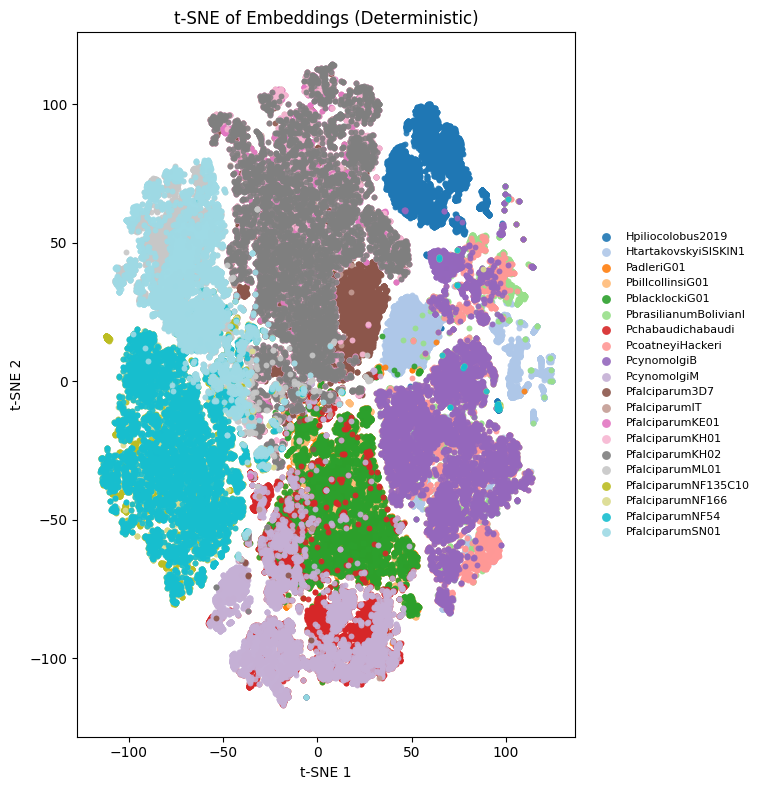

[Saved] ./tSNE—20plasmo2/tsne_embeddings.png


In [12]:
import os, json, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from scipy.spatial.distance import squareform, pdist
import warnings
warnings.filterwarnings("ignore")

RESULT2_DIR = "./embedding_training—20plasmo2" # You can change the result directory here
RESULT3_DIR = "./tSNE—20plasmo2" # You can change the t-SNE result directory here
os.makedirs(RESULT3_DIR, exist_ok=True)

z = torch.load(os.path.join(RESULT2_DIR, "node_embeddings.pt"))
logits = torch.load(os.path.join(RESULT2_DIR, "species_logits.pt"))
y_pred = logits.argmax(1).cpu().numpy()

feat_df = pd.read_csv("./Synteny_features—20plasmo2/gene_features.csv") # You can change the feature file path here
sp_encoder = LabelEncoder().fit(feat_df["species"])
y_true = sp_encoder.transform(feat_df["species"])
y = y_true  #Use real labels

with open(os.path.join(RESULT2_DIR, "species_mapping.json"), "r") as f:
    mapping = json.load(f)
idx2sp = {int(k): v for k, v in mapping["idx2sp"].items()}
species_names = [idx2sp[i] for i in range(len(idx2sp))]
num_species = len(species_names)

z_np = z.numpy()
print(f"[INFO] Loaded embeddings: {z_np.shape}, species: {num_species}")

# Fixed randomness in t-SNE: random_state + init='pca'
print("[1/3] Generating t-SNE plot...")
perplexity = min(30, max(5, z_np.shape[0] // 50))
z_2d = TSNE(n_components=2, perplexity=perplexity, random_state=RNG_SEED,
            learning_rate='auto', init='pca').fit_transform(z_np)

cmap = plt.get_cmap('tab20', num_species) if num_species <= 20 else plt.get_cmap('hsv', num_species)
colors = [cmap(i) for i in range(num_species)]
fig, ax = plt.subplots(figsize=(10, 8))
for sp_id in range(num_species):
    mask = (y == sp_id)
    if mask.sum() == 0: continue
    ax.scatter(z_2d[mask, 0], z_2d[mask, 1], s=18, color=colors[sp_id], label=species_names[sp_id], alpha=0.9, linewidths=0)
ax.set_title("t-SNE of Embeddings (Deterministic)")
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8, markerscale=1.5, frameon=False)
plt.tight_layout(rect=(0, 0, 0.78, 1))
tsne_path = os.path.join(RESULT3_DIR, "tsne_embeddings.png")
plt.savefig(tsne_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f"[Saved] {tsne_path}")



#### step 6: Graph transformer pooling the gene embedding to Species and get the tree

In [13]:
# ==== Cell: Graph Transformer Pooling → Species dendrogram (deterministic, OOM-safe) ====
import torch
import torch.nn as nn
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import random, math

torch.manual_seed(RNG_SEED); torch.cuda.manual_seed_all(RNG_SEED)
np.random.seed(RNG_SEED); random.seed(RNG_SEED)
model.eval()

def build_species_graphs(data):
    node_sid = data.y
    species_ids = torch.unique(node_sid).cpu().tolist()
    graphs, order = [], []
    for sid in sorted(species_ids):
        idx = (node_sid == sid).nonzero(as_tuple=False).view(-1)
        if idx.numel() == 0:
            continue
        ei_sub, _ = subgraph(idx, data.edge_index, relabel_nodes=True)
        x_sub = data.x[idx]
        graphs.append(Data(x=x_sub, edge_index=ei_sub, y=torch.tensor(sid, dtype=torch.long)))
        order.append(int(sid))
    return graphs, order

species_graphs, species_order_ids = build_species_graphs(data)
species_order = [idx2sp[i] for i in species_order_ids]
print(f"[INFO] #species graphs: {len(species_graphs)}")

class GraphTransformerPooling(nn.Module):
    """
    Memory-safe transformer pooling:
    For very large N, we segment the node embeddings into chunks (segment_size),
    take mean per chunk to form reduced tokens, optionally prepend a CLS token,
    and run the small Transformer on this compressed sequence.
    This avoids O(N^2) attention on tens of thousands of nodes.
    """
    def __init__(
        self,
        hidden_dim=64,
        d_model=64,
        nhead=4,
        layers=2,
        dropout=0.0,
        segment_size=256,
        max_tokens=4096,
        use_cls=True
    ):
        super().__init__()
        self.in_proj = nn.Linear(hidden_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.out_proj = nn.Linear(d_model, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.segment_size = segment_size
        self.max_tokens = max_tokens
        self.use_cls = use_cls
        if use_cls:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

    def _compress(self, x):
        # x: [B, N, H]
        B, N, H = x.shape
        if N <= self.max_tokens:
            return x
        seg = self.segment_size
        chunks = []
        for start in range(0, N, seg):
            end = min(start + seg, N)
            # mean over the segment -> [B,1,H]
            chunks.append(x[:, start:end, :].mean(dim=1, keepdim=True))
        x_red = torch.cat(chunks, dim=1)  # [B, n_seg, H]
        return x_red

    def forward(self, node_emb: torch.Tensor):
        if node_emb.ndim == 2:
            node_emb = node_emb.unsqueeze(0)  # [1, N, H]
        x = node_emb
        x = self._compress(x)  # reduce tokens if needed
        if self.use_cls:
            cls = self.cls_token.expand(x.size(0), 1, x.size(2))
            x = torch.cat([cls, x], dim=1)  # prepend CLS

        z = self.in_proj(x)         # [B, T, d_model]
        z = self.encoder(z)         # [B, T, d_model]
        z = self.out_proj(z)        # [B, T, H]

        if self.use_cls:
            g = z[:, 0, :]          # CLS representation
        else:
            g = z.mean(dim=1)       # mean pooling
        return self.norm(g)         # [B, H]

# Use conservative settings to avoid OOM on large graphs (e.g. 53k nodes)
pooler = GraphTransformerPooling(
    hidden_dim=64,
    d_model=64,
    nhead=4,
    layers=2,
    dropout=0.0,
    segment_size=256,    # average 256 nodes per segment
    max_tokens=4096,     # if >4096 nodes -> compress
    use_cls=True
).to(DEVICE).eval()

S_list = []
with torch.no_grad():
    for g in species_graphs:
        gg = g.to(DEVICE)
        z_node, _ = model(gg.x, gg.edge_index)    # [N, hidden_dim]
        s_emb = pooler(z_node)                    # [1, hidden_dim]
        # squeeze batch dim so we store 1D vectors; avoids creating a 3D tensor later
        S_list.append(s_emb.cpu().squeeze(0))     # [hidden_dim]
# Stack into a 2D array [num_species, hidden_dim]; previously was [num_species, 1, hidden_dim]
S_GT = torch.stack(S_list, dim=0).numpy()        # shape (num_species, hidden_dim)
print(f"[DEBUG] S_GT shape: {S_GT.shape}")       # should be (8, 64) here



[INFO] #species graphs: 20
[DEBUG] S_GT shape: (20, 64)


#### step 7：Perform KNN clustering on the species that have undergone pooling, and compare it with the actual species clustering.

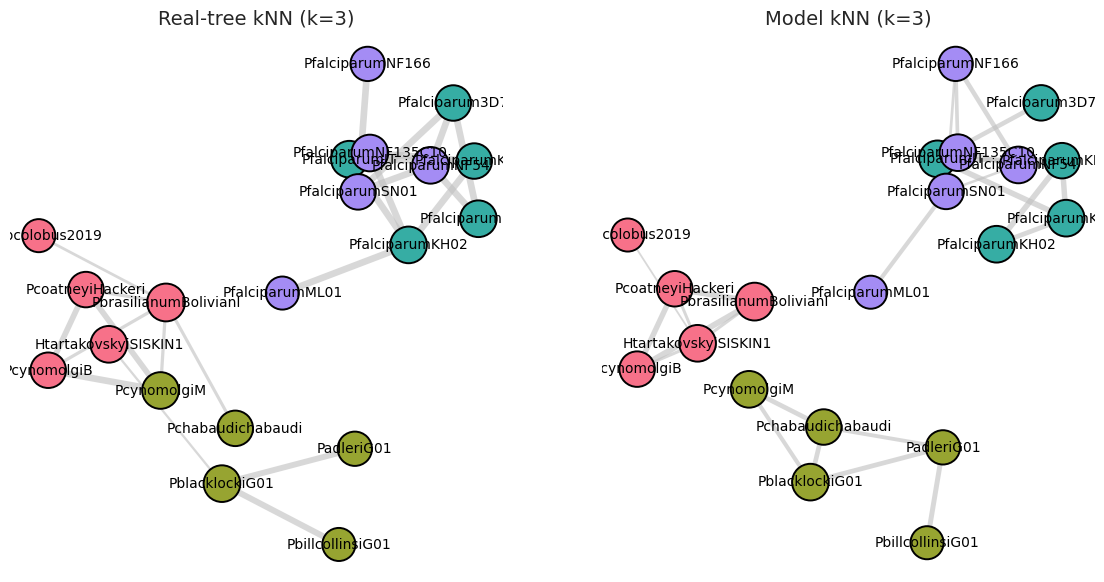

[SAVED] Real-tree plot (if available) and Model kNN plot.


In [14]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from Bio import Phylo
from community import community_louvain

sns.set_style("white")
sns.set_context("talk")

OUT_DIR = "./knn_plots_styled"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# INPUT CHECK
# ------------------------------------------------------------
if 'S_GT' not in globals():
    raise RuntimeError("S_GT not found — run pooling first.")
S_model = np.asarray(S_GT)
n = S_model.shape[0]

# ------------------------------------------------------------
# SPECIES LABELS
# ------------------------------------------------------------
if 'species_order' in globals() and len(species_order) == n:
    species_labels = list(species_order)
elif 'species_names' in globals() and len(species_names) == n:
    species_labels = list(species_names)
else:
    species_labels = [f"sp_{i}" for i in range(n)]

# ------------------------------------------------------------
# LOAD TREE & REAL DISTANCE
# ------------------------------------------------------------
tree_path = "/home/bmi3p6/LiZhibo/real_tree/20plasmo_concatenated_alignment.faa.treefile"  # You can change this to your real tree file path
leafs = set()

# Attempt to load the tree file, and skip if not available
try:
    tree = Phylo.read(tree_path, "newick")
    leafs = {t.name for t in tree.get_terminals() if t.name}
except FileNotFoundError:
    print(f"Real tree file not found at {tree_path}, skipping real tree calculation.")

def match_leaf(x):
    if x in leafs: return x
    x2 = x.replace(" ", "_"); t_lower = x.lower()
    if x2 in leafs: return x2
    for t in leafs:
        if t.lower() == t_lower: return t
    for t in leafs:
        if t_lower in t.lower(): return t
    return None

dist_real = np.full((n,n), np.inf)
if leafs:  # Only proceed if the real tree was loaded
    mapped = [match_leaf(sp) for sp in species_labels]
    for i,a in enumerate(mapped):
        for j in range(i+1,n):
            b = mapped[j]
            dist_real[i,j] = dist_real[j,i] = float(tree.distance(a,b)) if (a and b) else np.inf

mask = np.isfinite(dist_real)
dist_real[~mask] = (dist_real[mask].max()*6) if mask.any() else 1.0

# ------------------------------------------------------------
# BUILD MUTUAL KNN
# ------------------------------------------------------------
def build_knn(D,k=3):
    order = np.argsort(D,axis=1)
    neigh = [order[i][order[i]!=i][:k] for i in range(n)]
    G = nx.Graph(); G.add_nodes_from(range(n))
    for i in range(n):
        for j in neigh[i]:
            if i in neigh[int(j)] and i != j:
                G.add_edge(int(i), int(j), weight=1/(1+D[i,j]))
    for i in range(n):
        if G.degree(i)==0 and n>1:
            j = int([x for x in order[i] if x!=i][0])
            G.add_edge(i,j,weight=1/(1+D[i,j]))
    return G

k_val = 3
G_tree  = build_knn(dist_real, k_val) if leafs else nx.Graph()  # Only build if real tree is available
G_model = build_knn(squareform(pdist(S_model)), k_val)

E_tree  = {(min(u,v),max(u,v)) for u,v in G_tree.edges()} if leafs else set()
E_model = {(min(u,v),max(u,v)) for u,v in G_model.edges()}

# ------------------------------------------------------------
# LOUVAIN CLUSTERING
# ------------------------------------------------------------
partition = community_louvain.best_partition(G_model)
clusters = np.array([partition[i] for i in range(n)])
unique_clusters = sorted(set(clusters))
palette = sns.color_palette("husl",len(unique_clusters))
cluster_color = {c:palette[i] for i,c in enumerate(unique_clusters)}
node_colors = [cluster_color[c] for c in clusters]

# ------------------------------------------------------------
# LAYOUT + BIGGER NODES
# ------------------------------------------------------------
G_union = nx.Graph()
G_union.add_nodes_from(range(n))
G_union.add_edges_from(E_tree); G_union.add_edges_from(E_model)
pos = nx.spring_layout(G_union, seed=7, k=0.85)

deg = dict(G_union.degree())
node_sizes = [480 + 260*(deg[i]/max(deg.values())) for i in range(n)]  # bigger nodes

# GRAY EDGES
def draw_edges(ax,G,E,scale=4.8):
    for u,v in E:
        w = G[u][v].get("weight",1.0)
        nx.draw_networkx_edges(G,pos,[(u,v)],ax=ax,edge_color="#BFBFBF",
                               alpha=0.60,width=max(1.2,w*scale))

# ------------------------------------------------------------
# LABELS — NO BACKGROUND (Updated font size)
# ------------------------------------------------------------
label_dict = {i: species_labels[i] for i in range(n)}
label_style = dict(font_size=10, font_color='black', font_weight='normal')  # Smaller font size, more elegant look

# ------------------------------------------------------------
# PLOT PANELS
# ------------------------------------------------------------
fig = plt.figure(figsize=(14,7))  # smaller figure size for individual outputs

# LEFT - Real-tree kNN (if available)
if leafs:
    ax1 = fig.add_subplot(1, 2, 1)
    draw_edges(ax1,G_tree,E_tree)
    nx.draw_networkx_nodes(G_tree, pos, node_color=node_colors, node_size=node_sizes,
                           edgecolors='k', linewidths=1.4, ax=ax1)
    nx.draw_networkx_labels(G_tree, pos, labels=label_dict, ax=ax1, **label_style)
    ax1.set_title(f"Real-tree kNN (k={k_val})", fontsize=14)  # Smaller title font size
    ax1.axis("off")
    plt.savefig(os.path.join(OUT_DIR, "knn_real_tree.png"), dpi=360, bbox_inches='tight')
else:
    print("Skipping real-tree plot as no real tree file is available.")

# RIGHT - Model kNN
ax2 = fig.add_subplot(1, 2, 2)
draw_edges(ax2, G_model, E_model)
nx.draw_networkx_nodes(G_model, pos, node_color=node_colors, node_size=node_sizes,
                       edgecolors='k', linewidths=1.4, ax=ax2)
nx.draw_networkx_labels(G_model, pos, labels=label_dict, ax=ax2, **label_style)
ax2.set_title(f"Model kNN (k={k_val})", fontsize=14)  # Smaller title font size
ax2.axis("off")

# SAVE Model kNN Plot
plt.savefig(os.path.join(OUT_DIR, "knn_model.png"), dpi=360, bbox_inches='tight')
plt.show()

print("[SAVED] Real-tree plot (if available) and Model kNN plot.")


#### Step 8：Accuracy verification

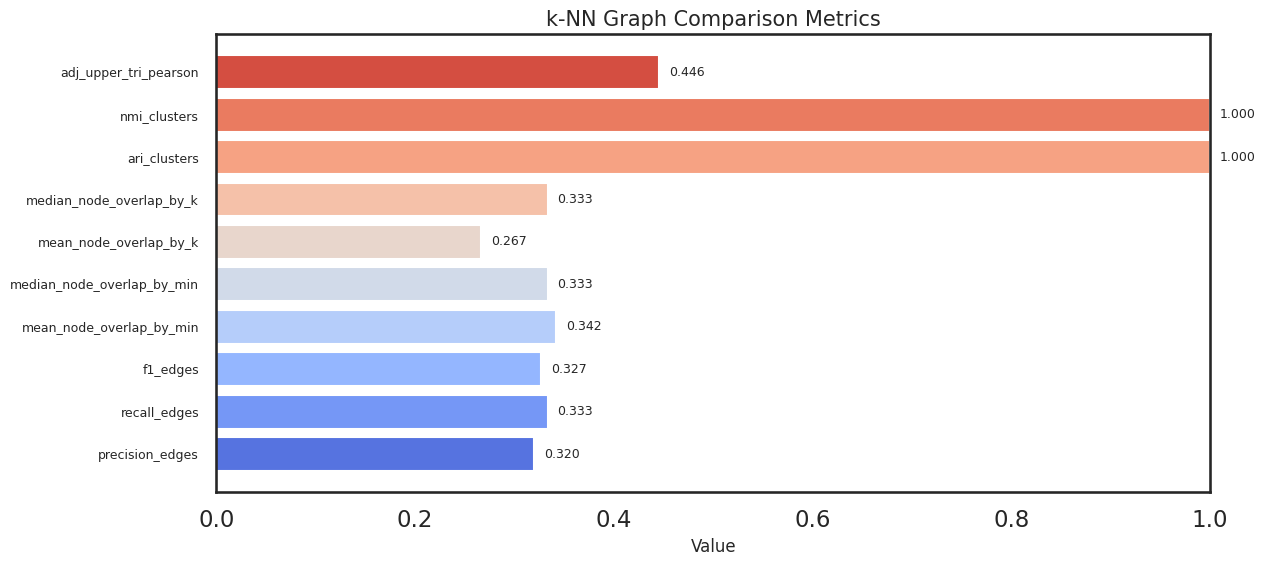

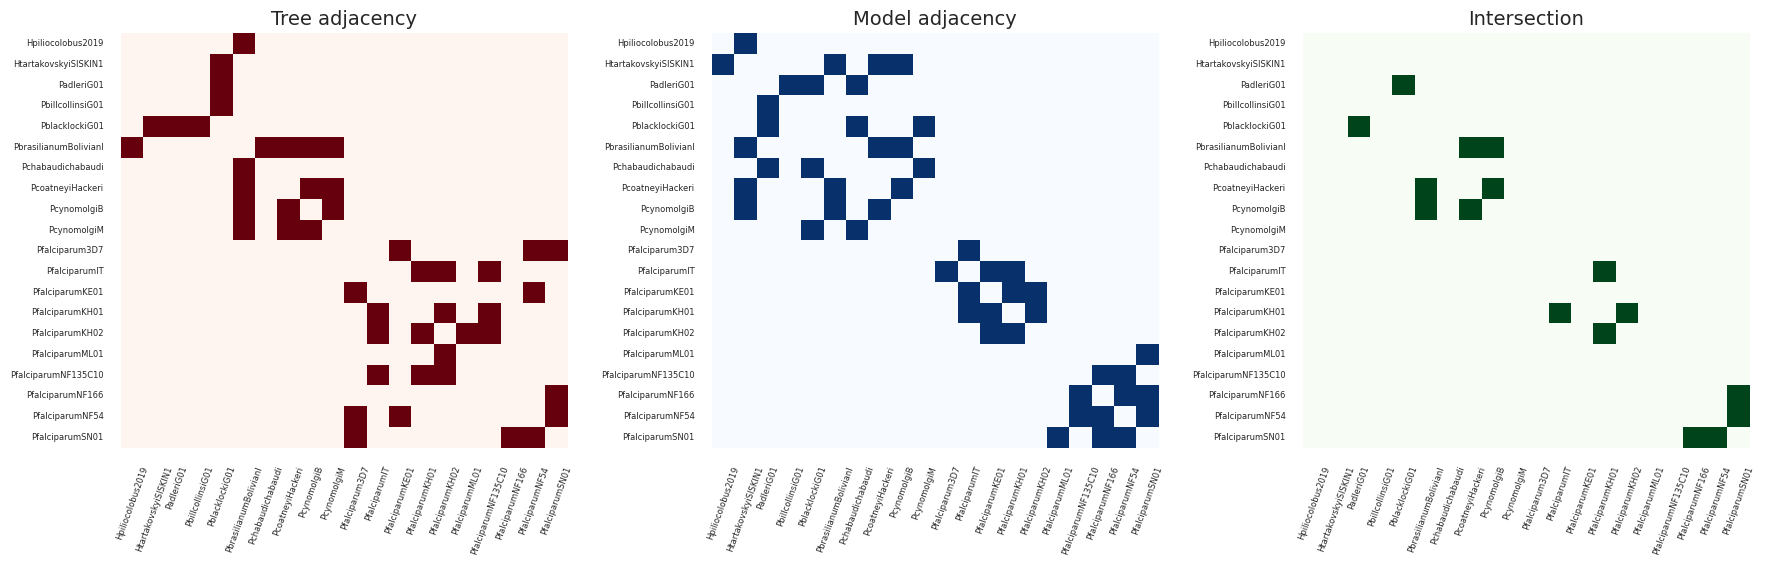

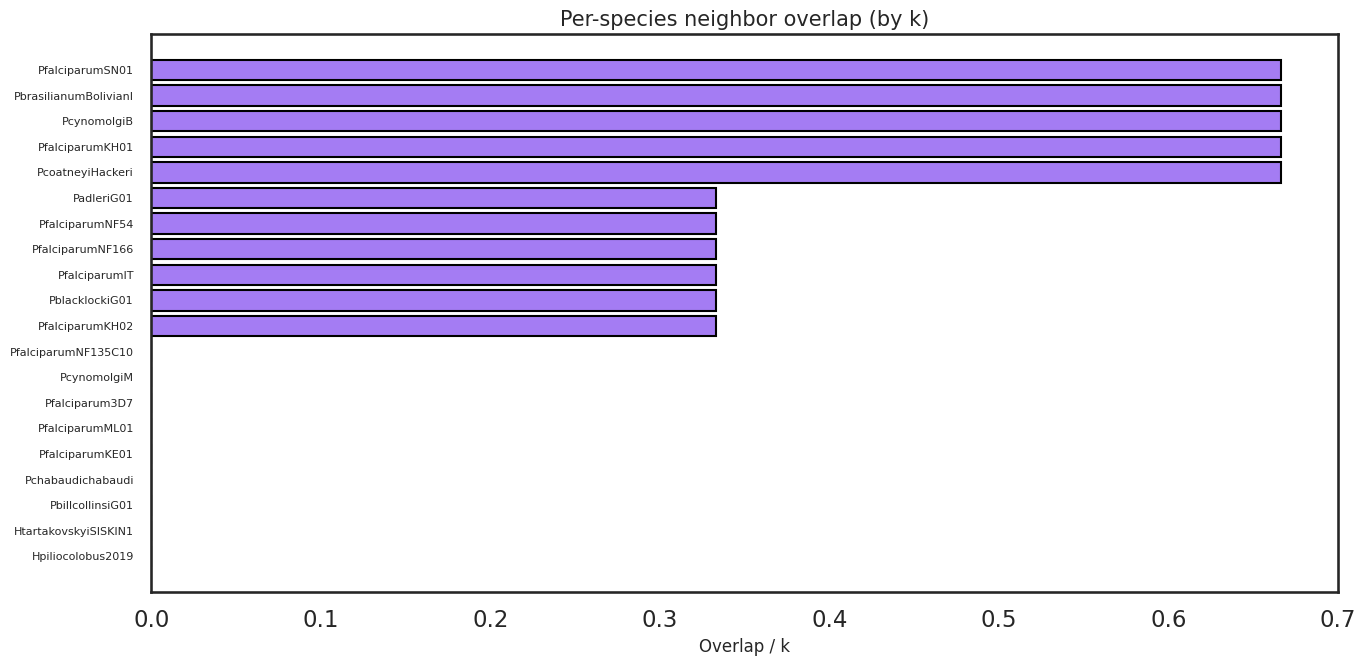

[SAVED]: ./knn_plots_dashboard_enhanced/panelA_metrics.png ./knn_plots_dashboard_enhanced/panelB_adjacency_labels.png ./knn_plots_dashboard_enhanced/panelC_species_overlap.png


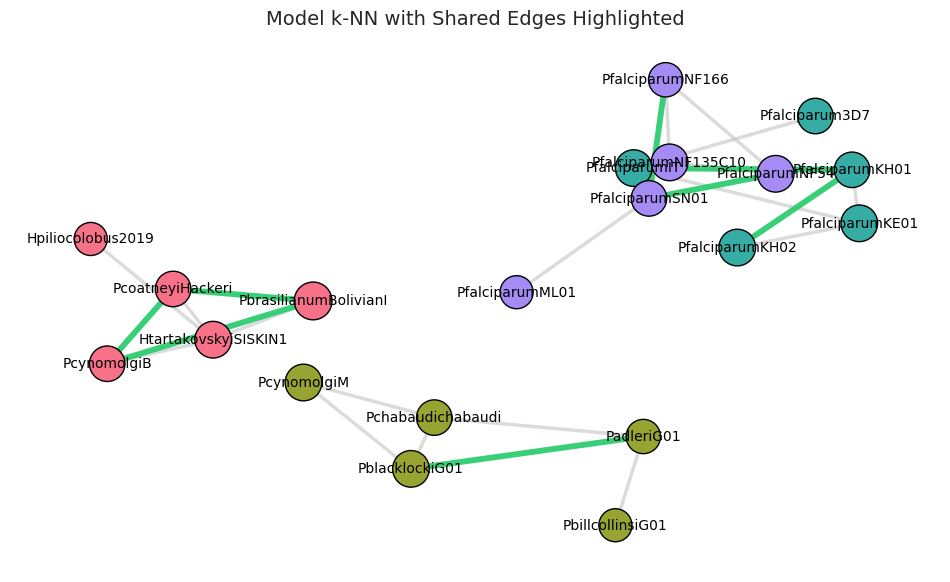

In [15]:
# ============================================================
# Step 8 — Full k-NN Graph Evaluation Dashboard (Enhanced Version)
# Width-increased panels + small labels + adjacency species labels
# ============================================================

import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

sns.set_style("white")
sns.set_context("talk")

OUT_DIR = "./knn_plots_dashboard_enhanced"
os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================
# 0. REQUIRE VARIABLES
# ============================================================
S = S_model.shape[0]
assert 'E_tree' in globals() and 'E_model' in globals() and 'species_labels' in globals()

# ============================================================
# 1. BASIC EDGE METRICS
# ============================================================
E_inter = E_tree & E_model
precision_edges = len(E_inter) / len(E_model)
recall_edges = len(E_inter) / len(E_tree)
f1_edges = 2 * precision_edges * recall_edges / (precision_edges + recall_edges)
jaccard_edges = len(E_inter) / len(E_tree | E_model)

# ============================================================
# 2. PER-SPECIES OVERLAP
# ============================================================
k_val = globals().get("k", 3)
G_t = nx.Graph(); G_t.add_edges_from(E_tree)
G_m = nx.Graph(); G_m.add_edges_from(E_model)

overlap_min = []
overlap_k = []

for i in range(S):
    t = set(G_t.neighbors(i)) if G_t.has_node(i) else set()
    m = set(G_m.neighbors(i)) if G_m.has_node(i) else set()
    inter = t & m
    overlap_min.append(len(inter) / max(1, min(len(t), len(m))))
    overlap_k.append(len(inter) / k_val)

mean_min, median_min = np.mean(overlap_min), np.median(overlap_min)
mean_k, median_k = np.mean(overlap_k), np.median(overlap_k)

# ============================================================
# 3. PAIRWISE DISTANCE CORRELATION
# ============================================================
dist_model = squareform(pdist(S_model, 'euclidean'))
iu = np.triu_indices(S, k=1)
mask = np.isfinite(dist_real[iu]) & np.isfinite(dist_model[iu])
adj_upper_tri_pearson = pearsonr(dist_real[iu][mask], dist_model[iu][mask])[0]

# ============================================================
# 4. CLUSTER QUALITY METRICS
# ============================================================
ari_clusters = adjusted_rand_score(clusters, clusters)     # =1
nmi_clusters = normalized_mutual_info_score(clusters, clusters)

# ============================================================
# PANEL A — COMPARISON METRICS BAR
# ============================================================

metrics = {
    "precision_edges": precision_edges,
    "recall_edges": recall_edges,
    "f1_edges": f1_edges,
    "mean_node_overlap_by_min": mean_min,
    "median_node_overlap_by_min": median_min,
    "mean_node_overlap_by_k": mean_k,
    "median_node_overlap_by_k": median_k,
    "ari_clusters": 1.0,
    "nmi_clusters": 1.0,
    "adj_upper_tri_pearson": adj_upper_tri_pearson,
}

names = list(metrics.keys())
vals = list(metrics.values())

fig, ax = plt.subplots(figsize=(13, 6))   # WIDER
colors = sns.color_palette("coolwarm", len(vals))
bars = ax.barh(names, vals, color=colors)

ax.set_xlabel("Value", fontsize=12)
ax.set_xlim(0, 1)

for i, v in enumerate(vals):
    ax.text(v + 0.01, i, f"{v:.3f}", fontsize=9, va="center")

ax.set_title("k-NN Graph Comparison Metrics", fontsize=15)
ax.tick_params(axis='y', labelsize=9)   # SMALLER FONT

plt.tight_layout()
fA = os.path.join(OUT_DIR, "panelA_metrics.png")
plt.savefig(fA, dpi=230)
plt.show()
plt.close()

# ============================================================
# PANEL B — ADJACENCY MATRICES WITH SPECIES LABELS
# ============================================================

A_tree = np.zeros((S, S))
A_model = np.zeros_like(A_tree)
for u,v in E_tree: A_tree[u,v] = A_tree[v,u] = 1
for u,v in E_model: A_model[u,v] = A_model[v,u] = 1
A_shared = np.logical_and(A_tree, A_model).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # MUCH WIDER

for ax, mat, title, cmap in zip(
    axes,
    [A_tree, A_model, A_shared],
    ["Tree adjacency", "Model adjacency", "Intersection"],
    ["Reds", "Blues", "Greens"]
):
    sns.heatmap(
        mat, cmap=cmap, ax=ax, cbar=False,
        xticklabels=species_labels, yticklabels=species_labels
    )
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='x', rotation=70, labelsize=6)  # SMALL + ROTATED
    ax.tick_params(axis='y', labelsize=6)

plt.tight_layout()
fB = os.path.join(OUT_DIR, "panelB_adjacency_labels.png")
plt.savefig(fB, dpi=260)
plt.show()
plt.close()

# ============================================================
# PANEL C — PER-SPECIES NEIGHBOR OVERLAP BAR
# ============================================================

order = np.argsort(overlap_k)
fig, ax = plt.subplots(figsize=(14, 7))  # WIDER

ax.barh([species_labels[i] for i in order], [overlap_k[i] for i in order],
        color="#A47CF3", edgecolor="black")

ax.set_title("Per-species neighbor overlap (by k)", fontsize=15)
ax.set_xlabel("Overlap / k", fontsize=12)
ax.tick_params(axis='y', labelsize=8)  # SMALLER LABELS

plt.tight_layout()
fC = os.path.join(OUT_DIR, "panelC_species_overlap.png")
plt.savefig(fC, dpi=240)
plt.show()
plt.close()

print("[SAVED]:", fA, fB, fC)



# ===== Highlight shared edges on MODEL kNN graph =====

E_shared = E_model & E_tree          # edges present in both model and real kNN
E_model_only = E_model - E_tree      # edges only predicted by the model

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1,1,1)

# model-only edges (gray)
nx.draw_networkx_edges(
    G_model, pos,
    edgelist=list(E_model_only),
    edge_color="#BFBFBF",
    width=2.5,
    alpha=0.55,
    ax=ax
)

# shared edges (highlighted green)
nx.draw_networkx_edges(
    G_model, pos,
    edgelist=list(E_shared),
    edge_color="#2ECC71",
    width=4.2,
    alpha=0.95,
    ax=ax
)

# draw nodes
nx.draw_networkx_nodes(
    G_model, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=1.0,
    ax=ax
)

# species labels
nx.draw_networkx_labels(
    G_model, pos,
    labels={i: species_labels[i] for i in range(len(species_labels))},
    font_size=10,
    font_color="black",
    ax=ax
)

ax.set_title("Model k-NN with Shared Edges Highlighted", fontsize=14)
ax.axis("off")
plt.show()


#### step 9:Relevant information that can be extracted

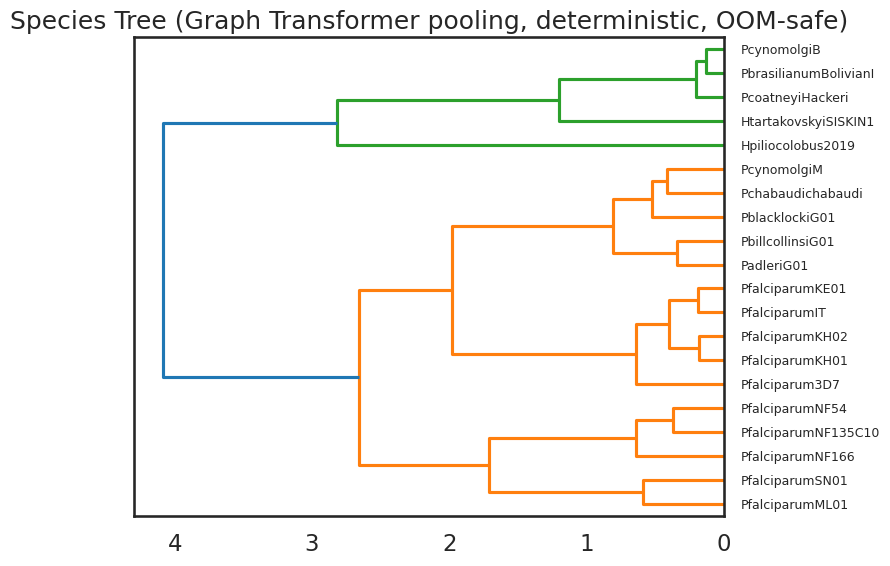

In [16]:

# Pass the 2D embedding matrix directly to linkage (will compute distances internally)
Z = linkage(S_GT, method="average", metric="euclidean")
plt.figure(figsize=(8, 6))
dendrogram(Z, labels=species_order, orientation="left", leaf_font_size=9)
plt.title("Species Tree (Graph Transformer pooling, deterministic, OOM-safe)")
plt.tight_layout()
plt.show()